In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
### Storage Setting
Ts = 1/12
c = 10
eta = 0.9

In [3]:
### Heterogeneous Storage Profit
ESD = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_Hete/EDESD.csv',header=None)
ESC = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_Hete/EDESC.csv',header=None)
price = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_Hete/EDprice.csv',header=None)
ES = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/Storage_C_4hr_5GW.csv')
ESmodel = pd.read_csv('output/Strategic/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio1.0_MIP0.1_DARTDP_Hete/Strategic/storage_to_index_map.csv')
ESmodelTrain = pd.read_csv('models/models_profit_julia_2_100_lr001.csv')

In [4]:
HeteroData = []
for i in ESmodel['StorageID']:
    index = i-1
    Zone = ES['Zone'][index]
    Capacity = ES['MaxCap(MWh)'][index]
    Revenue = sum((ESD[index]-ESC[index])*price[ES['Zone'][index]])/1000
    Profit = sum((ESD[index]-ESC[index])*price[ES['Zone'][index]] - Ts*c*ESD[index])/1000
    UnitProfit = Profit/Capacity
    ModelID = ESmodel[ESmodel['StorageID']==i]['SelectedModelIndex'].item()
    TrainProfit = ESmodelTrain['Training profit'][ModelID-1]/1000
    
    HeteroData.append({
        'Storage ID': i,
        'Zone': Zone,
        'Capacity': Capacity,
        'Revenue': Revenue,
        'Profit': Profit,
        'UnitProfit': UnitProfit,
        'ModelID': ModelID,
        'TrainProfit': TrainProfit
    })
HeteroDatadf = pd.DataFrame(HeteroData)
Zone2ES = HeteroDatadf[HeteroDatadf['Zone']==2]

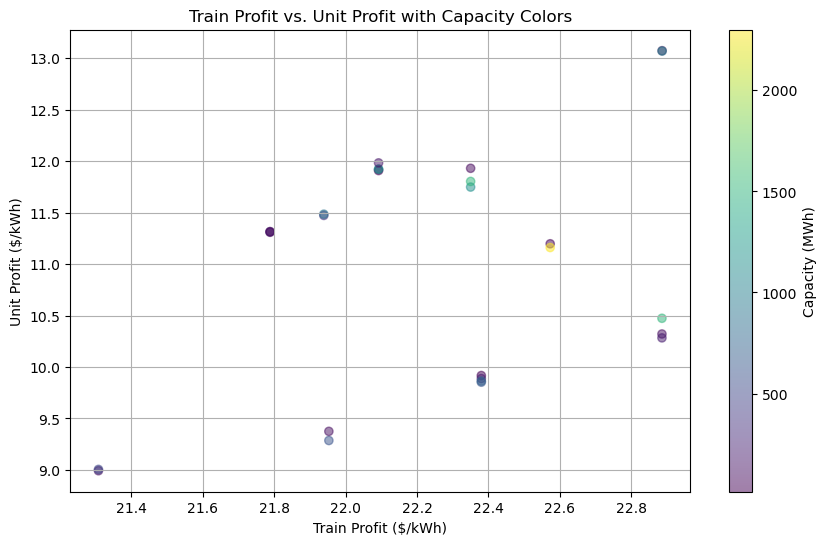

In [5]:
plt.figure(figsize=(10, 6))
# Using capacity as the color variable
scatter = plt.scatter(Zone2ES['TrainProfit'], Zone2ES['UnitProfit'], c=Zone2ES['Capacity'], cmap='viridis', alpha=0.5)

# Adding a color bar to indicate the capacity values
cbar = plt.colorbar(scatter)
cbar.set_label('Capacity (MWh)')

plt.title('Train Profit vs. Unit Profit with Capacity Colors')

plt.xlabel('Train Profit ($/kWh)')
plt.ylabel('Unit Profit ($/kWh)')
plt.grid(True)
plt.show()

In [ ]:
### Price Analysis
# price = pd.read_csv('output/Strategic/Scale/UC25ED1_Strategic_true_Seg5_Load1.0_Fuel1.2_Error0.25_ratio0.5_MIP0.1_DARTDP/EDprice.csv',header=None)
# df = pd.concat([price.mean()*12, (price*12).std()], axis=1)
# df.T

In [6]:
### Emission
ThermalGen = pd.read_csv('2032 ADS PCM V2.4.1 Public Data/Processed Data/ThermalGen_Full_C.csv')
case = 'Strategic/Scale/UC25ED1_Strategic_true_Seg1_Load1.0_Fuel1.2_Error0.25_ratio0.1_MIP0.1_DARTDP'
EDGen = pd.read_csv('output/'+case+'/EDGen.csv',header=None)

In [8]:
def distribute_output_across_segments(interval_output, thermalgen_row):
    """
    Distribute a single interval's output across the generator's operational segments.

    :param interval_output: The total output for the generator in a 5-minute interval.
    :param thermalgen_row: A pandas Series containing the generator's segment data.
    :return: A list where each element represents the output allocated to a segment.
    """
    # Initialize variables
    segment_outputs = []  # Stores the output allocated to each segment
    remaining_output = interval_output
    
    # Base segment output
    if remaining_output > 0:
        base_output = min(remaining_output, thermalgen_row['IOMinCap(MW)'])
        segment_outputs.append(base_output)
        remaining_output -= base_output
    else:
        segment_outputs.append(0)

    # Incremental segments
    for i in range(2, 7):  # Assuming up to 6 segments
        inc_cap_key = f'IncCap{i}(MW)'
        if inc_cap_key in thermalgen_row.index and thermalgen_row[inc_cap_key] > 0:
            if remaining_output > 0:
                segment_capacity = thermalgen_row[inc_cap_key]
                segment_output = min(remaining_output, segment_capacity)
                segment_outputs.append(segment_output)
                remaining_output -= segment_output
            else:
                segment_outputs.append(0)
        else:
            break  # No more segments defined

    # If there are less than 6 segments, fill the remaining with 0s
    while len(segment_outputs) < 6:
        segment_outputs.append(0)

    return segment_outputs

In [ ]:
# Initialize a dictionary to store the interval outputs for each segment
interval_segment_outputs = {gen_id: [] for gen_id in EDGen.columns}

for gen_id in EDGen.columns:
    thermalgen_row = ThermalGen.loc[gen_id]  # Adjust this line based on how you match generators
    
    for interval_output in EDGen[gen_id]:
        segment_outputs = distribute_output_across_segments(interval_output, thermalgen_row)
        interval_segment_outputs[gen_id].append(segment_outputs)

In [ ]:
# Placeholder for the aggregated hourly segment outputs
hourly_segment_outputs = {gen_id: pd.DataFrame(columns=[f'Segment{i}' for i in range(1, 7)]) for gen_id in EDGen.columns}

for gen_id, outputs in interval_segment_outputs.items():
    # Convert list of outputs to DataFrame for easier manipulation
    outputs_df = pd.DataFrame(outputs, columns=[f'Segment{i}' for i in range(1, 7)])
    
    # Aggregate to hourly by summing every 12 rows (12 intervals per hour)
    hourly_data = outputs_df.groupby(outputs_df.index // 12).sum()
    
    hourly_segment_outputs[gen_id] = hourly_data

In [ ]:
hourly_segment_outputs

In [ ]:
EDGen[14].values.reshape(-1, 12)


In [11]:
ThermalGen

,Unnamed: 0,Generator Name,If Use Generic IO Curve,Generic IO Curve Name,IONumBlock,IOMaxCap(MW),IOMinCap(MW),MinInput(MMBTu),IncCap2(MW),IncHR2(MMBTu/MWh),...,Start Up Cost($),NoLoadCost($),IncCost2($/MW),IncCost3($/MW),IncCost4($/MW),IncCost5($/MW),IncCost6($/MW),Fuel Cost($/MMBTu)_y,Fuel Name_Start.1,Fuel Cost($/MMBTu)
0,0,Ox_Mountain7,False,NaN,2,1.9,0.57,6.9080,1.33,12.120,...,11.155225,16.432495,28.830608,0.000000,0.000000,0.000000,0.0,2.378763,Bio_Landfill_Gas,2.378763
1,1,Ox_Mountain6,False,NaN,4,1.9,0.57,9.6890,0.38,11.819,...,11.155225,23.047835,28.114600,29.548994,32.862611,0.000000,0.0,2.378763,Bio_Landfill_Gas,2.378763
2,2,Ox_Mountain5,False,NaN,4,1.9,0.57,9.6890,0.38,11.819,...,11.155225,23.047835,28.114600,29.548994,32.862611,0.000000,0.0,2.378763,Bio_Landfill_Gas,2.378763
3,3,Ox_Mountain4,False,NaN,4,1.9,0.57,9.6890,0.38,11.819,...,11.155225,23.047835,28.114600,29.548994,32.862611,0.000000,0.0,2.378763,Bio_Landfill_Gas,2.378763
4,4,Ox_Mountain3,False,NaN,4,1.9,0.57,9.6890,0.38,11.819,...,11.155225,23.047835,28.114600,29.548994,32.862611,0.000000,0.0,2.378763,Bio_Landfill_Gas,2.378763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,1297,Griffith CC1b,False,NaN,5,299.0,132.50,989.7137,36.50,5.286,...,23244.730873,3494.498947,18.663904,21.128415,23.592926,32.744806,0.0,3.530818,NG_AZ_North,3.530818
1298,1298,IRC Generator Facility Agg,False,NaN,1,3.0,3.00,157.5600,0.00,0.000,...,130.282465,556.315684,0.000000,0.000000,0.000000,0.000000,0.0,3.530818,NG_AZ_North,3.530818
1299,1299,Columbia Ridge Landfill Agg,False,NaN,2,12.8,4.00,47.3930,8.80,7.366,...,130.267871,158.690085,24.664216,0.000000,0.000000,0.000000,0.0,3.348387,NG_Oregon_OR and WA,3.348387
1300,1300,Farm Power Agg,False,NaN,1,2.0,2.00,157.5600,0.00,0.000,...,130.267871,527.571790,0.000000,0.000000,0.000000,0.000000,0.0,3.348387,NG_Oregon_OR and WA,3.348387
